# 📊 Photo-Z Challenge: Model Evaluation & Validation

Now it's time to see how well it performs. 🕵️‍♂️ 
In this notebook, we will load the validation dataset and the weights of your trained model to run inference. We will evaluate the predictions by comparing the predicted redshift ($Z_{PRED}$) to the true redshift ($Z_{TRUE}$). 

We will look at three main metrics:
1. **Bias**: The median of the redshift error.
2. **Precision ($\sigma_{NMAD}$)**: The Normalized Median Absolute Deviation.
3. **Outlier Fraction**: The percentage of catastrophic failures where the error is too large.

Let's configure our environment first! 🛠️

In [1]:
import os
import yaml
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import gaussian_kde
from sklearn.ensemble import RandomForestRegressor
import joblib

# --- 2. PLOTTING STYLE ---
# Applying dark background and user-specified scaling preferences
plt.style.use('dark_background')
plt.rcParams.update({
    'font.size': 14,          
    'axes.labelsize': 18,     
    'axes.titlesize': 20,     
    'xtick.labelsize': 14,    
    'ytick.labelsize': 14,    
    'legend.fontsize': 14,    
    'lines.linewidth': 3,
    'axes.grid': False        # Ensure grids are removed globally
})

TYPE_COLORS = {
    'GALAXY': 'tab:cyan',
    'QSO': 'tab:red',
    'GALAXY_ID': 'tab:blue',
    'GALAXY_HIGH_Z': 'tab:purple',
    'GALAXY_MISSING_BANDS': 'tab:orange',
    'GALAXY_OFFSET': 'tab:pink',
    'Passive': 'tab:orange',
    'ELG': 'tab:green'
}

/var/folders/6r/hl4s187n5b37619mh7d94nb40000gn/T/ipykernel_84635/3151291332.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## ⚙️ Step 1: Configuration & Model Architectures

To keep this notebook self-contained, we define the configuration and model architectures directly here. Make sure this configuration matches exactly the one used to train the model.

In [38]:
# Configuration dictionary
cfg = {
    "experiment": {
        "group_name": "Deep-Z",
        "save_dir": "models/"
    },
    "data": {
        "train_path": "data/training_set.h5", # Adjusted path assuming notebook is in photoz_challenge/
        "val_path": "data/validation_set.h5",
        "batch_size": 1000,
        "target_col": "Z",
        "inputs": {
            "FilterJPAS": [
                'J0378', 'J0390', 'J0400', 'J0410', 'J0420', 'J0430', 'J0440', 'J0450',
                'J0460', 'J0470', 'J0480', 'J0490', 'J0500', 'J0510', 'J0520', 'J0530',
                'J0540', 'J0550', 'J0560', 'J0570', 'J0580', 'J0590', 'J0600', 'J0610',
                'J0620', 'J0630', 'J0640', 'J0650', 'J0660', 'J0670', 'J0680', 'J0690',
                'J0700', 'J0710', 'J0720', 'J0730', 'J0740', 'J0750', 'J0760', 'J0770',
                'J0780', 'J0790', 'J0800', 'J0810', 'J0820', 'J0830', 'J0840', 'J0850',
                'J0860', 'J0870', 'J0880', 'J0890', 'J0900', 'J0910'
            ],
            "MAGNITUDES": [
                'MAG_NUV','MAG_FUV','MAG_G','MAG_R','MAG_i','MAG_Z',"MAG_J_2MASS",
                "MAG_H_2MASS","MAG_Ks_2MASS",'MAG_W1','MAG_W2','MAG_W3','MAG_W4', 'iSDSS'
            ]
        },
        "selected_features": ["FilterJPAS", "MAGNITUDES"],
        "features_to_normalize": ["MAGNITUDES"]
    },
    "model": {
        "type": "neural_net", # Options: "neural_net", "random_forest"
        "hidden_layers": [512, 512],
        "dropout_rates": [0.2, 0.2],
        "output_size": 1,
        "n_estimators": 100,
        "max_depth": 20
    },
    "training": {
        "epochs": 20,
        "learning_rate": 0.001,
        "loss_type": "deltaz"
    }
}
# Model Definitions required to load weights
class PhotoZNet(nn.Module):
    def __init__(self, input_size, hidden_layers, dropout_rates):
        super(PhotoZNet, self).__init__()
        layers = []
        in_dim = input_size
        for h_dim, drop_rate in zip(hidden_layers, dropout_rates):
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(drop_rate))
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, 1))
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)

class RandomForestPhotoZ:
    def __init__(self, n_estimators=100, max_depth=None):
        self.model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=42)
    def load(self, path):
        self.model = joblib.load(path)
    def predict(self, X):
        preds = np.array([tree.predict(X) for tree in self.model.estimators_])
        return np.mean(preds, axis=0), np.std(preds, axis=0)

## 🧮 Step 2: Data Processing & Metrics Logic

Here we define the logic to calculate our main metrics. 

**Crucial detail**: Notice that we use the `train_stats` to normalize our validation data. 

In [39]:
def get_mad(series):
    median = series.median()
    return (series - median).abs().median()

def get_point_density(x, y):
    xy = np.vstack([x, y])
    if xy.shape[1] > 5000:
        indices = np.random.choice(xy.shape[1], 5000, replace=False)
        z = gaussian_kde(xy[:, indices])(xy)
    else:
        z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    return x[idx], y[idx], z[idx]

def preprocess_data(df, config, train_stats=None):
    selected_cols = []
    for group in config['data']['selected_features']:
        selected_cols.extend(config['data']['inputs'][group])
    
    X = df[selected_cols].copy()
    y = df['Z'].values if 'Z' in df.columns else np.where(df['SPECTYPE'] == 2.0, df['Z_QSO'], df['Z_GAL'])
    types = df['TYPE'].values
    X = X.fillna(0.0)

    cols_to_norm = []
    for group in config['data']['features_to_normalize']:
        if group in config['data']['selected_features']:
             cols_to_norm.extend(config['data']['inputs'][group])
    
    if train_stats is None:
        medians = X[cols_to_norm].median()
        mads = X[cols_to_norm].apply(get_mad).replace(0, 1.0)
        train_stats = {'medians': medians, 'mads': mads}
    
    X[cols_to_norm] = (X[cols_to_norm] - train_stats['medians']) / train_stats['mads']
    return X.values, y, types, train_stats, len(selected_cols)

def compute_metrics_binned(df, x_col, z_true_col='Z', z_pred_col='Z_PRED', bins=None):
    if bins is None: return None, None, None, None
    centers, bias_list, sigma_list, outlier_list = [], [], [], []
    dz = (df[z_pred_col] - df[z_true_col]) / (1 + df[z_true_col])
    
    for i in range(len(bins) - 1):
        mask = (df[x_col] >= bins[i]) & (df[x_col] < bins[i+1])
        subset_dz = dz[mask]
        
        if len(subset_dz) < 100: 
            centers.append(np.nan); bias_list.append(np.nan); sigma_list.append(np.nan); outlier_list.append(np.nan)
            continue
            
        centers.append(0.5 * (bins[i] + bins[i+1]))
        bias_list.append(np.median(subset_dz))
        sigma_list.append(1.4826 * np.median(np.abs(subset_dz - np.median(subset_dz))))
        outlier_list.append(np.sum(np.abs(subset_dz) > 0.15) / len(subset_dz))

    return np.array(centers), np.array(bias_list), np.array(sigma_list), np.array(outlier_list)

## 🎨 Step 3: Inline Visualization Functions

These functions will generate our three main evaluations:
1. **Scatter Plots**: Predicted vs True Redshift.
2. **Performance Metrics**: Bias, Precision, and Outlier Fraction binned by magnitude and redshift.
3. **NLL (Negative Log-Likelihood)**: To evaluate how well our model predicts its own uncertainty (if applicable).

In [40]:
import os

import matplotlib.pyplot as plt
import numpy as np

plt.style.use('dark_background')

def get_smart_limits(data, margin=0.05):
    """Helper to calculate smart axis limits filtering extreme outliers."""
    if len(data) == 0: return 0, 1
    p1 = np.percentile(data, 1)
    p99 = np.percentile(data, 99)
    rng = p99 - p1
    return p1 - (rng * margin), p99 + (rng * margin)

def plot_predictions_inline(df, types):
    n_cols = len(types)
    fig, axs = plt.subplots(2, n_cols, figsize=(22, 16)) 
    
    for i, t in enumerate(types):
        subset = df[df['TYPE'] == t]
        if len(subset) == 0: continue
        z_true = subset['Z'].values
        z_pred = subset['Z_PRED'].values
        mag_i = subset['MAG_i'].values
        
        ax_dens = axs[0, i] if n_cols > 1 else axs[0]
        ax_mag = axs[1, i] if n_cols > 1 else axs[1]
        
        # Smart axis limits filtering extreme outliers
        z_min, z_max = get_smart_limits(np.concatenate([z_true, z_pred]))
        z_lim = (max(0, z_min), z_max)
        
        # Row 1: Density
        x_d, y_d, z_d = get_point_density(z_true, z_pred)
        sc1 = ax_dens.scatter(x_d, y_d, c=z_d, s=15, cmap='plasma')
        ax_dens.plot(z_lim, z_lim, 'w--', alpha=0.5, linewidth=5)
        ax_dens.set_title(f"{t} ", fontsize=30)
        ax_dens.set_xlabel('Z True', fontsize=30); ax_dens.set_ylabel('Z Predicted', fontsize=30)
        ax_dens.set_xlim(z_lim); ax_dens.set_ylim(z_lim)
        ax_dens.tick_params(axis='both', labelsize=30)
        ax_dens.grid(False)
        if i == n_cols - 1: plt.colorbar(sc1, ax=ax_dens).set_label('Point Density', size=30)

        # Row 2: Magnitude
        sc2 = ax_mag.scatter(z_true, z_pred, c=mag_i, s=15, cmap='viridis_r', alpha=0.7)
        ax_mag.plot(z_lim, z_lim, 'w--', alpha=0.5, linewidth=5)
        ax_mag.set_xlabel('Z True', fontsize=30); ax_mag.set_ylabel('Z Predicted', fontsize=30)
        ax_mag.set_xlim(z_lim); ax_mag.set_ylim(z_lim)
        ax_mag.tick_params(axis='both', labelsize=30)
        ax_mag.grid(False)
        if i == n_cols - 1: plt.colorbar(sc2, ax=ax_mag).set_label('$i$', size=30)

    plt.tight_layout()
    plt.show()

def plot_metrics_inline(df, title_prefix, filter_condition=None):
    data = df[filter_condition].copy() if filter_condition is not None else df.copy()
    fig, axs = plt.subplots(2, 3, figsize=(24, 16))
    fig.suptitle(f'{title_prefix}', fontsize=36, weight='bold')
    
    bins_mag = np.arange(17, 23.3 + 0.25, 0.25)
    bins_z = np.arange(0, 1.0 + 0.1, 0.1)
    
    for t in data['TYPE'].unique():
        subset = data[data['TYPE'] == t]
        if len(subset) < 10: continue
        lbl = f"{t} (N={len(subset)})"
        col = TYPE_COLORS.get(t, 'white')
        
        x_m, bias_m, sig_m, out_m = compute_metrics_binned(subset, 'MAG_i', 'Z', 'Z_PRED', bins_mag)
        axs[0, 0].plot(x_m, bias_m, label=lbl, color=col, marker='o', markersize=12, linewidth=5)
        axs[0, 1].plot(x_m, sig_m, label=lbl, color=col, marker='o', markersize=12, linewidth=5)
        axs[0, 2].plot(x_m, (out_m * 100) + 1e-6, label=lbl, color=col, marker='o', markersize=12, linewidth=5)
        
        x_z, bias_z, sig_z, out_z = compute_metrics_binned(subset, 'Z', 'Z', 'Z_PRED', bins_z)
        axs[1, 0].plot(x_z, bias_z, label=lbl, color=col, marker='o', markersize=12, linewidth=5)
        axs[1, 1].plot(x_z, sig_z, label=lbl, color=col, marker='o', markersize=12, linewidth=5)
        axs[1, 2].plot(x_z, (out_z * 100) + 1e-6, label=lbl, color=col, marker='o', markersize=12, linewidth=5)

    for ax in axs.flat:
        ax.tick_params(axis='both', labelsize=30)
        ax.grid(False)

    for ax in axs[0, :]: ax.set_xlabel('$i$', fontsize=30); ax.set_xlim(17, 23.3)
    for ax in axs[1, :]: ax.set_xlabel('Z True', fontsize=30); ax.set_xlim(0, 1.0)
    
    axs[0, 0].set_ylabel('Bias $\Delta z$', fontsize=30); axs[1, 0].set_ylabel('Bias $\Delta z$', fontsize=30)
    
    axs[0, 1].set_ylabel('$\sigma_{NMAD}$ (log)', fontsize=30); axs[1, 1].set_ylabel('$\sigma_{NMAD}$ (log)', fontsize=30)
    axs[0, 1].set_yscale('log'); axs[1, 1].set_yscale('log')
    
    axs[0, 2].set_ylabel('Outlier % (log)', fontsize=30); axs[1, 2].set_ylabel('Outlier % (log)', fontsize=30)
    axs[0, 2].set_yscale('log'); axs[1, 2].set_yscale('log')

    axs[0, 0].legend(loc='upper left', fontsize=25, frameon=True)
    plt.tight_layout()
    plt.show()

def plot_nll_inline(df, types):
    n_cols = len(types)
    fig, axs = plt.subplots(1, n_cols, figsize=(22, 8)) 
    if n_cols == 1: axs = [axs]
    fig.suptitle('NLL vs True Redshift', fontsize=36, weight='bold')
    
    variance = np.maximum(df['Z_PRED_STD']**2, 1e-6)
    df['NLL'] = 0.5 * np.log(2 * np.pi * variance) + ((df['Z'] - df['Z_PRED'])**2) / (2 * variance)
    
    for i, t in enumerate(types):
        subset = df[df['TYPE'] == t]
        if len(subset) == 0: continue
        z_true = subset['Z'].values
        nll = subset['NLL'].values
        
        ax = axs[i]
        x_d, y_d, z_d = get_point_density(z_true, nll)
        sc = ax.scatter(x_d, y_d, c=z_d, s=15, cmap='plasma')
        
        z_min, z_max = get_smart_limits(z_true)
        nll_min, nll_max = get_smart_limits(nll)
        
        ax.set_title(f"{t}", fontsize=30)
        ax.set_xlabel('Z True', fontsize=30); ax.set_ylabel('NLL', fontsize=30)
        ax.set_xlim((max(0, z_min), z_max))
        ax.set_ylim((nll_min, nll_max))
        ax.tick_params(axis='both', labelsize=30)
        ax.grid(False)
        
        if i == n_cols - 1: plt.colorbar(sc, ax=ax).set_label('Point Density', size=30)

    plt.tight_layout()
    plt.show()

## 🚀 Step 4: Run Inference and Evaluate!

It's showtime! 🍿 This final cell brings everything together:
1. Loads datasets and normalization statistics.
2. Runs inference using your trained weights.
3. Prints a summary table of the global metrics.

Loading datasets to calculate normalization...
Loading Neural Network from models/Deep-Z.pth...

📈 GENERATING EVALUATION PLOTS



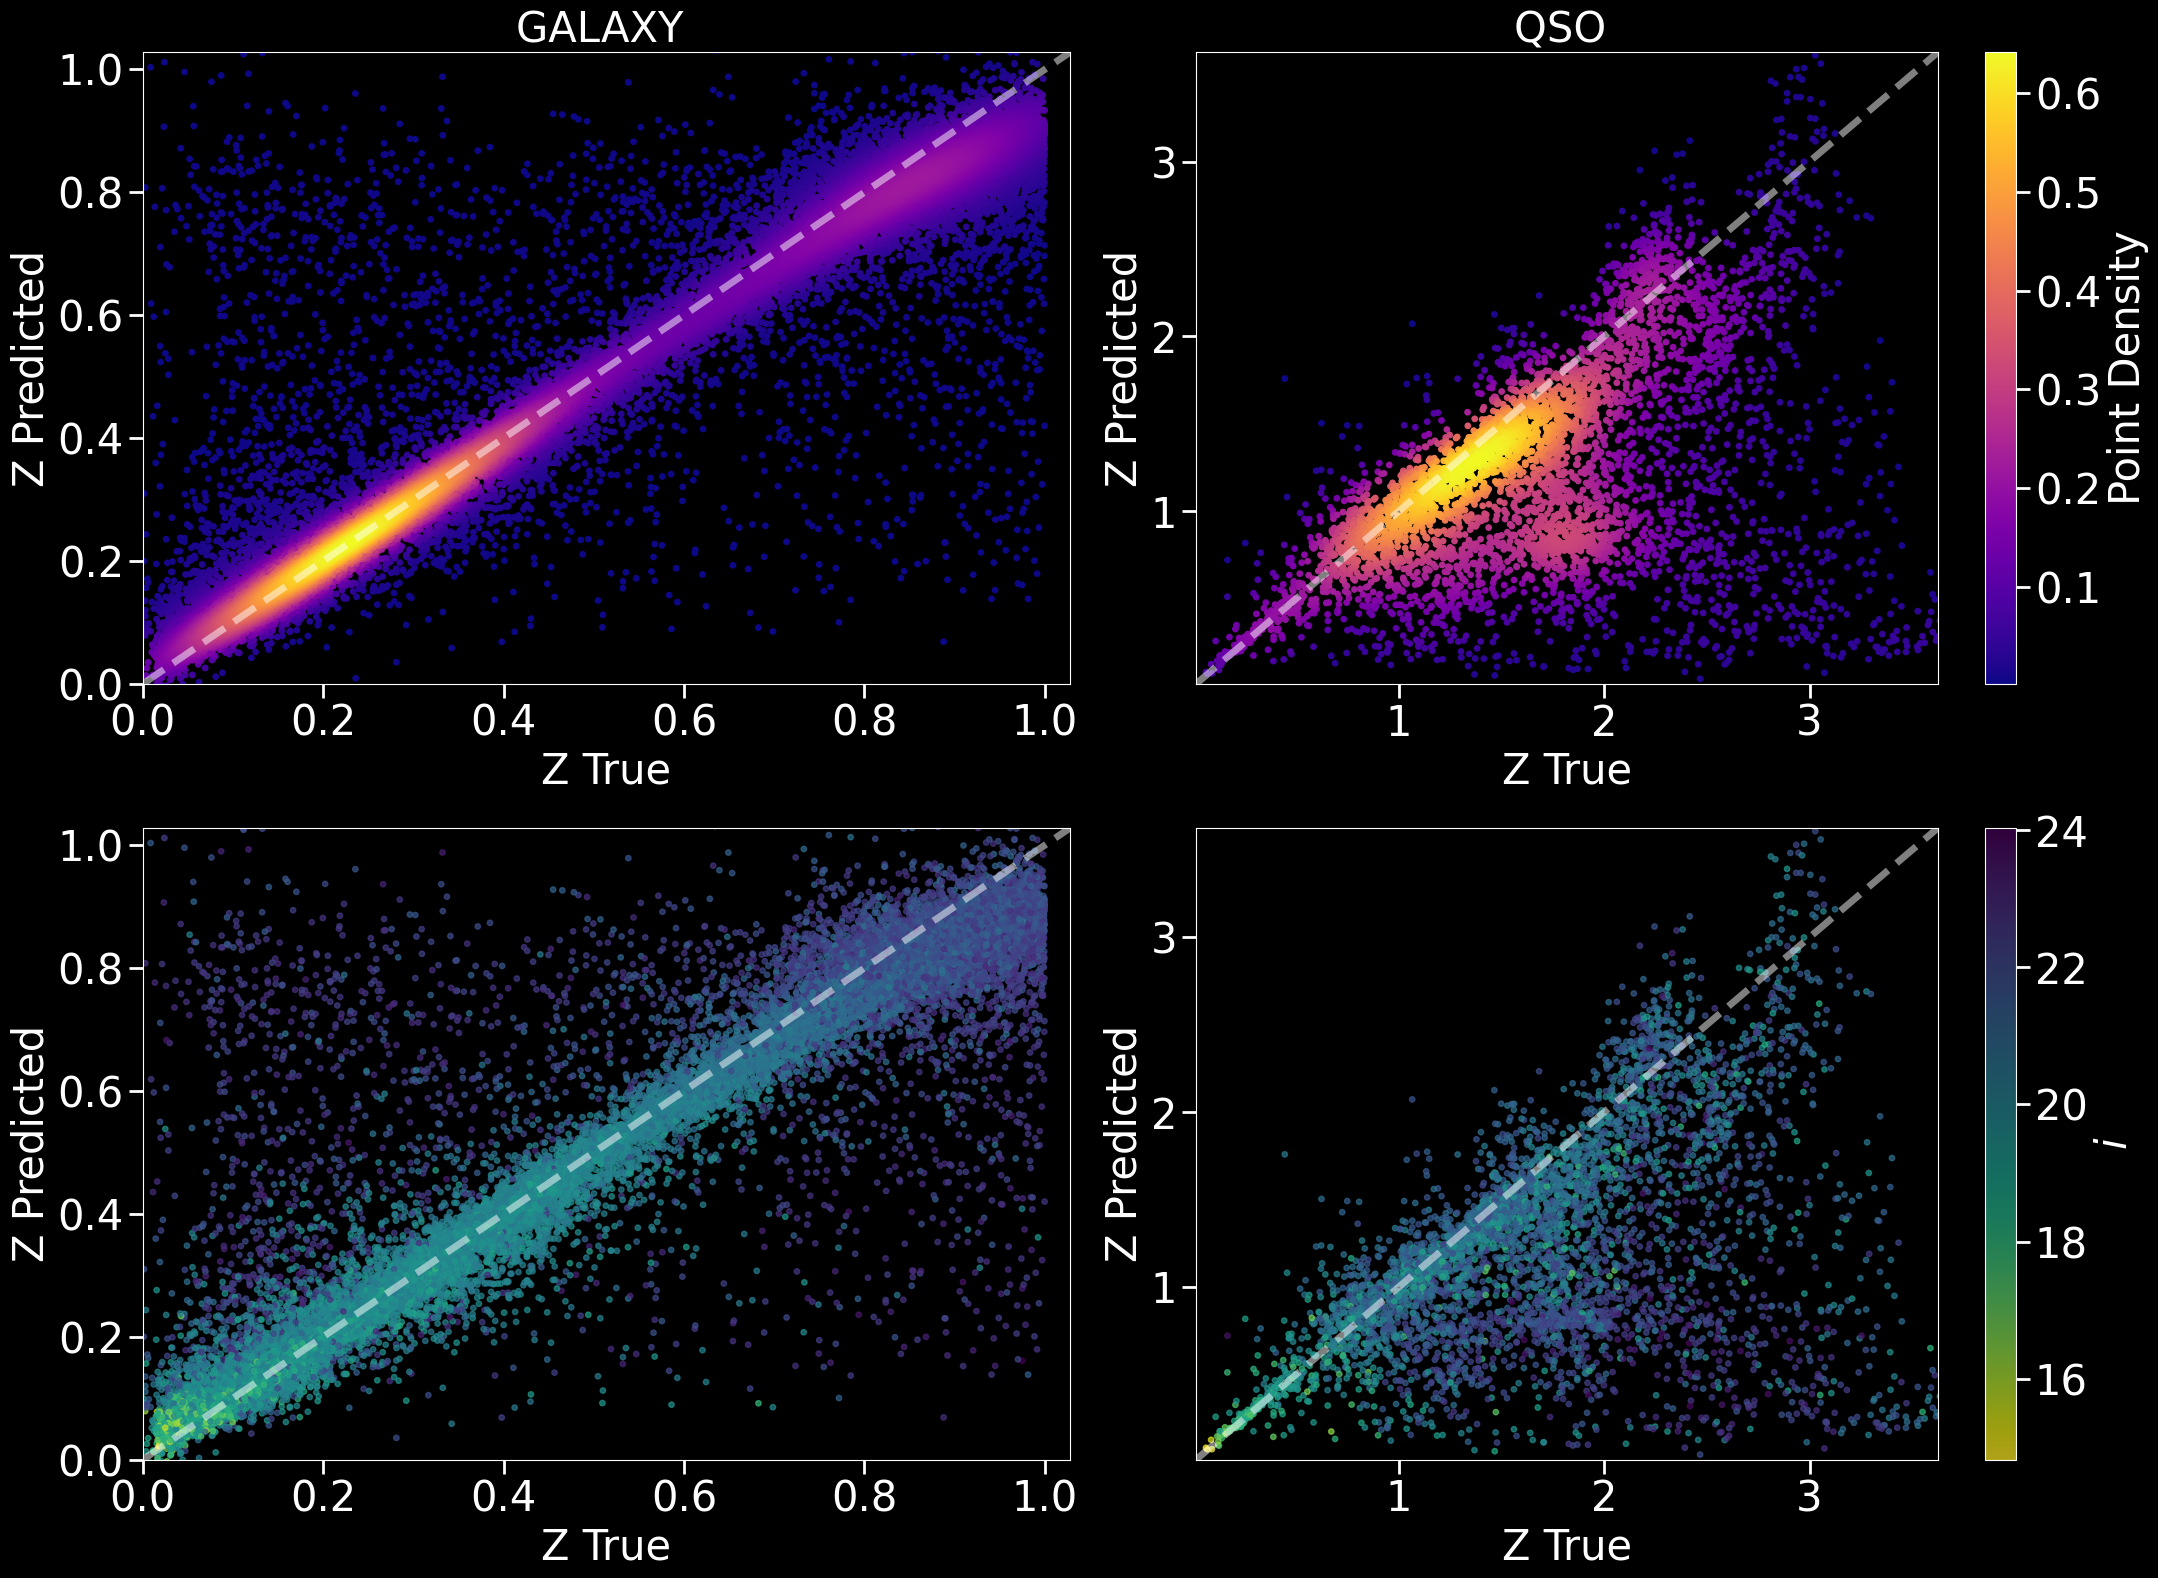

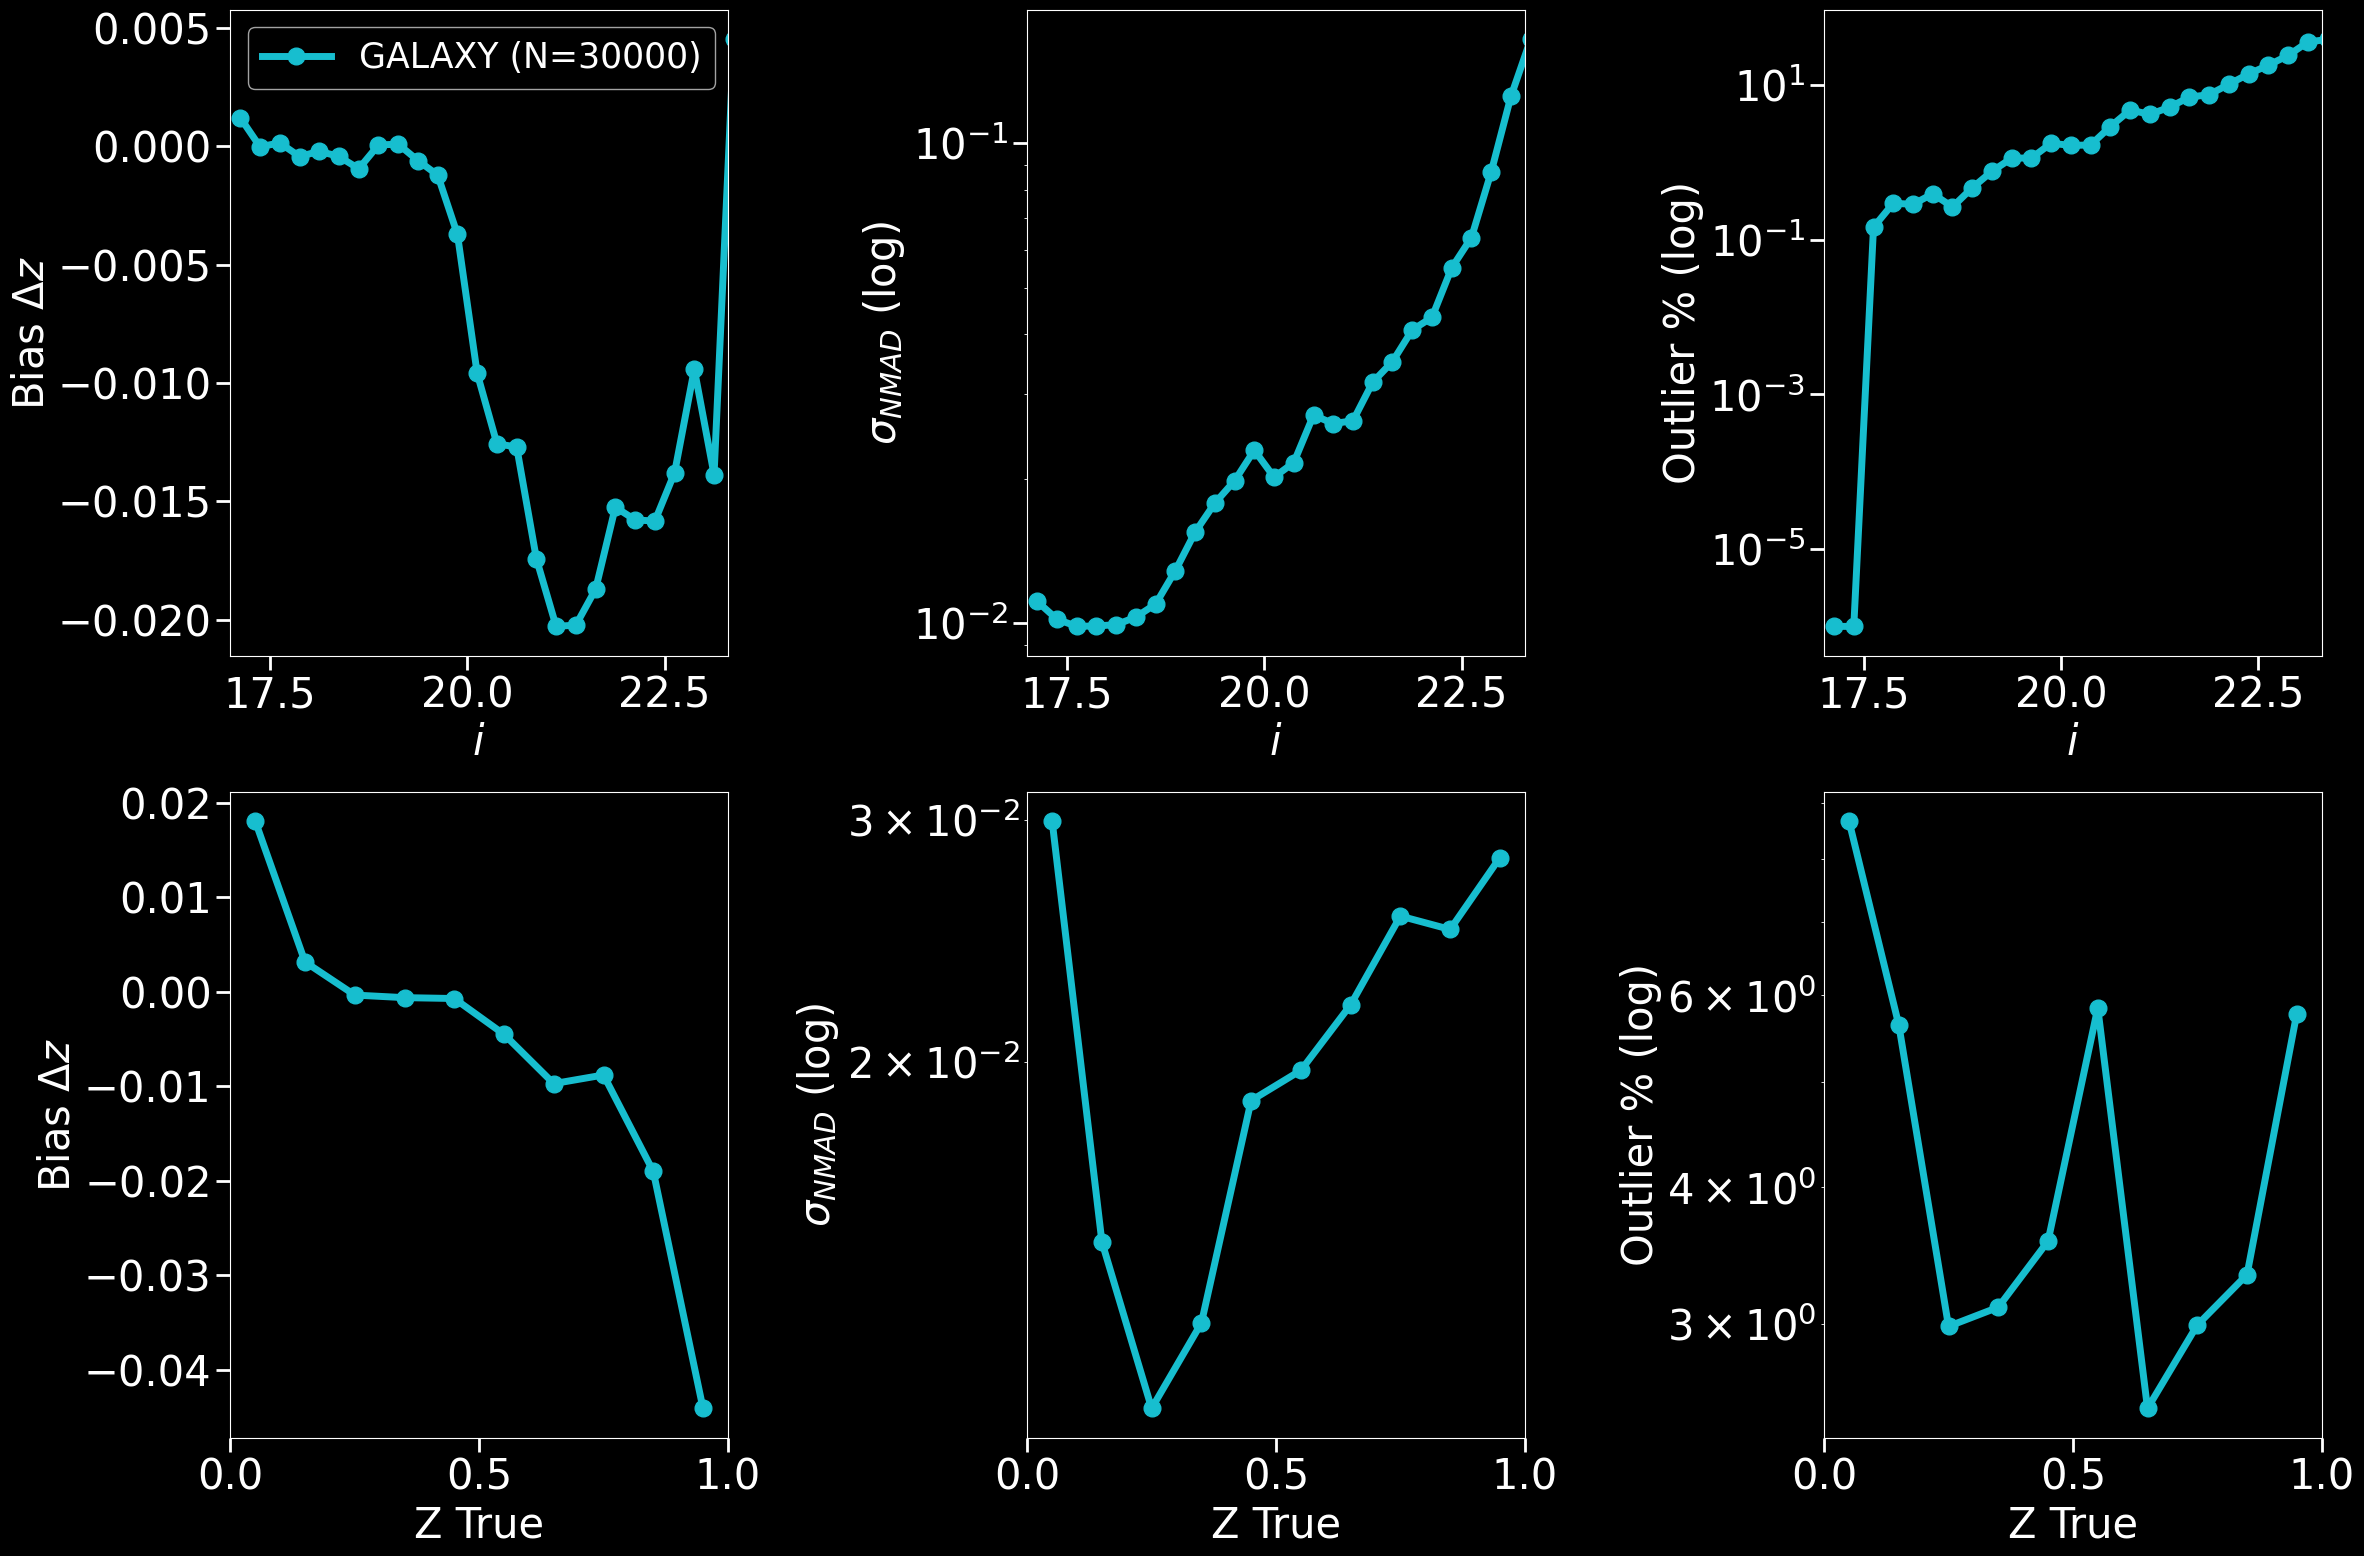


--- Global Metrics Table ---
  TYPE  Bias Global  Sigma_NMAD Global  Outlier % Global
GALAXY    -0.002521           0.020795          4.333333
   QSO    -0.097231           0.173829         43.660000


In [41]:
import os


import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configure global plot style: dark background, larger text/ticks, wider lines, and no grid
plt.style.use('dark_background')
plt.rcParams.update({
    'axes.labelsize': 30,
    'axes.titlesize': 30,
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'xtick.major.size': 10,
    'ytick.major.size': 10,
    'xtick.major.width': 2,
    'ytick.major.width': 2,
    'lines.linewidth': 5.0,
    'axes.grid': False,
    'legend.fontsize': 30
})

def run_inline_evaluation(config):
    print("Loading datasets to calculate normalization...")
    df_train = pd.read_hdf(config['data']['train_path'], key='data')
    df_val = pd.read_hdf(config['data']['val_path'], key='data')
    _, _, _, stats, input_dim = preprocess_data(df_train, config, train_stats=None)
    X_val_norm, _, _, _, _ = preprocess_data(df_val, config, train_stats=stats)
    
    model_type = config['model'].get('type', 'neural_net')
    
    if model_type == 'neural_net':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = PhotoZNet(input_dim, config['model']['hidden_layers'], config['model']['dropout_rates']).to(device)
        model_path = os.path.join(config['experiment']['save_dir'], f"{config['experiment']['group_name']}.pth")
        print(f"Loading Neural Network from {model_path}...")
        model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
        model.eval()
        
        with torch.no_grad():
            preds = model(torch.FloatTensor(X_val_norm).to(device)).cpu().numpy().flatten()
            
    elif model_type == 'random_forest':
        model = RandomForestPhotoZ()
        model_path = os.path.join(config['experiment']['save_dir'], f"{config['experiment']['group_name']}_rf.joblib")
        print(f"Loading Random Forest from {model_path}...")
        model.load(model_path)
        preds, std_preds = model.predict(X_val_norm)
        df_val['Z_PRED_STD'] = std_preds
    
    df_val['Z_PRED'] = preds
    if 'Z' not in df_val.columns:
        df_val['Z'] = np.where(df_val['SPECTYPE'] == 2.0, df_val['Z_QSO'], df_val['Z_GAL'])
        
    print("\n" + "="*50)
    print("📈 GENERATING EVALUATION PLOTS")
    print("="*50 + "\n")
    
    plot_predictions_inline(df_val, ['GALAXY', 'QSO'])
    plot_metrics_inline(df_val, "", df_val['TYPE'] == 'GALAXY')
    
    if 'Z_PRED_STD' in df_val.columns:
        plot_nll_inline(df_val, ['GALAXY', 'QSO'])
            
    print("\n--- Global Metrics Table ---")
    metrics = []
    for t in ['GALAXY', 'QSO']:
        subset = df_val[df_val['TYPE'] == t]
        if len(subset) > 0:
            dz = (subset['Z_PRED'] - subset['Z']) / (1 + subset['Z'])
            metrics.append({
                'TYPE': t, 
                'Bias Global': np.median(dz), 
                'Sigma_NMAD Global': 1.4826 * np.median(np.abs(dz - np.median(dz))), 
                'Outlier % Global': (np.sum(np.abs(dz) > 0.15) / len(dz)) * 100
            })
    
    if metrics: 
        print(pd.DataFrame(metrics).to_string(index=False))

# --- EXECUTION ---
# Uncomment the line below to run the visual evaluation!
run_inline_evaluation(cfg)